## Sentiment Analysis of Amazon Food Review

In [1]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata


In [2]:
df=pd.read_csv('Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df.ProductId.nunique()

74258

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
#Size of the dataset
df.shape

(568454, 10)

In [6]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [7]:
#Drop unwanted columns
df.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time'],axis=1,inplace=True)

In [8]:
#dropping duplicates
df.drop_duplicates(subset=['Text'],inplace=True)  
#dropping na
df.dropna(axis=0,inplace=True)  

In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 393576 entries, 0 to 568453
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Score    393576 non-null  int64 
 1   Summary  393576 non-null  object
 2   Text     393576 non-null  object
dtypes: int64(1), object(2)
memory usage: 12.0+ MB


In [10]:
#final size of the dataset
df.shape

(393576, 3)

In [11]:
#sample review
df['Text'].iloc[10000]

'I love this popcorn! I like popcorn very much, but I usually eat too much of it. I keep these bags at work for when I want a snack. If I had the big bags, I would eat the whole thing. These are perfect...it seems like you get a big pile of popcorn, but know you still are okay with calories compared to a candy bar (or even 4-5 hershey kisses!) I have tried other 100-calorie things and it is like you get some pitiful amount, but the popcorn seems like a real treat!<br /><br />I see it is currently out of stock and not available for subscribe and save :(  I hope they get more because it is really the most tasty/buttery flavored of the brands I have tried.'

## Cleaning Text data

#### Removing HTML tags

Often, unstructured text contains a lot of noise, especially if  use techniques like web or screen scraping. HTML tags are typically one of these components which don’t add much value towards understanding and analyzing text.

In [12]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

df['clean_text']=df['Text'].apply(lambda x:strip_html_tags(x))

In [13]:
df['clean_text'].iloc[10000]

'I love this popcorn! I like popcorn very much, but I usually eat too much of it. I keep these bags at work for when I want a snack. If I had the big bags, I would eat the whole thing. These are perfect...it seems like you get a big pile of popcorn, but know you still are okay with calories compared to a candy bar (or even 4-5 hershey kisses!) I have tried other 100-calorie things and it is like you get some pitiful amount, but the popcorn seems like a real treat!I see it is currently out of stock and not available for subscribe and save :(  I hope they get more because it is really the most tasty/buttery flavored of the brands I have tried.'

It is quite evident from the above output that we  removed unnecessary HTML tags and retain the useful textual information from the review.

#### Expanding Contractions

Contractions are the shortened versions of words like don’t for do not and how’ll for how will. These are used to reduce the speaking and writing time of words. We need to expand these contractions for a better analysis of the reviews.

Here, I have created a dictionary of common English contractions that I will use for mapping the contractions to their expanded forms:

In [14]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [15]:
df.clean_text[10]

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.Thank you for the personal, incredible service!"

In [16]:
def remove_contractions(text):
    text = text.lower() #lowercase all words
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text

df['clean_text']=df['clean_text'].apply(lambda x:remove_contractions(x))

In [17]:
df.clean_text[10]

'i do not know if it is the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  we picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  when we realized that we simply could not find it anywhere in our city we were bummed.now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.if you love hot sauce..i mean really love hot sauce, but do not want a sauce that tastelessly burns your throat, grab a bottle of tequila picante gourmet de inclan.  just realize that once you taste it, you will never want to use any other sauce.thank you for the personal, incredible service!'

So, using the function "remove_contractions" I have removed all the contractions in the reviews.

#### Removing Special Characters

Special characters and symbols are usually non-alphanumeric characters or even occasionally numeric characters (depending on the problem), which add to the extra noise in unstructured text. Usually, simple regular expressions (regexes) can be used to remove them.

In [18]:
df['clean_text'].iloc[10000]

'i love this popcorn! i like popcorn very much, but i usually eat too much of it. i keep these bags at work for when i want a snack. if i had the big bags, i would eat the whole thing. these are perfect...it seems like you get a big pile of popcorn, but know you still are okay with calories compared to a candy bar (or even 4-5 hershey kisses!) i have tried other 100-calorie things and it is like you get some pitiful amount, but the popcorn seems like a real treat!i see it is currently out of stock and not available for subscribe and save :(  i hope they get more because it is really the most tasty/buttery flavored of the brands i have tried.'

In [19]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text
df['clean_text']=df['clean_text'].apply(lambda x:remove_special_characters(x))

In [20]:
df['clean_text'].iloc[10000]

'i love this popcorn i like popcorn very much but i usually eat too much of it i keep these bags at work for when i want a snack if i had the big bags i would eat the whole thing these are perfectit seems like you get a big pile of popcorn but know you still are okay with calories compared to a candy bar or even 45 hershey kisses i have tried other 100calorie things and it is like you get some pitiful amount but the popcorn seems like a real treati see it is currently out of stock and not available for subscribe and save   i hope they get more because it is really the most tastybuttery flavored of the brands i have tried'

I’ve kept removing digits as optional, because often we might need to keep them in the pre-processed text.

#### Lemmatization

Lemmatisation is the algorithmic process of determining the lemma of a word based on its intended meaning. Remove word affixes to get to the base form of a word. However, the base form in this case is known as the root word, also known as the lemma, will always be present in the dictionary.

In [21]:
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 

def lemmatize(text):
        lemmatizer = WordNetLemmatizer()
        lemmatized_output = ' '.join(lemmatizer.lemmatize(x, 'v') for x in word_tokenize(text))
        return lemmatized_output
df['clean_text']=df['clean_text'].apply(lambda x:lemmatize(x))

In [22]:
df['clean_text'].iloc[10000]

'i love this popcorn i like popcorn very much but i usually eat too much of it i keep these bag at work for when i want a snack if i have the big bag i would eat the whole thing these be perfectit seem like you get a big pile of popcorn but know you still be okay with calories compare to a candy bar or even 45 hershey kiss i have try other 100calorie things and it be like you get some pitiful amount but the popcorn seem like a real treati see it be currently out of stock and not available for subscribe and save i hope they get more because it be really the most tastybuttery flavor of the brand i have try'

#### Removing Stopwords

Words which have little or no significance, especially when constructing meaningful features from text, are known as stopwords or stop words. These are usually words that end up having the maximum frequency if you do a simple term or word frequency in a corpus. Typically, these can be articles, conjunctions, prepositions and so on. Some examples of stopwords are a, an, the, and the like.

In [23]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
def remove_stopwords(text):
        token = word_tokenize(text)
        remove_short = [x for x in token if len(x)>2 ] #remove words that are shorter than 2 letters
        #remove stopwords and put sentence back together
        remove_output = ' '.join(x for x in remove_short if x not in stop_words) 
        return remove_output
df['clean_text']=df['clean_text'].apply(lambda x:remove_stopwords(x))

In [24]:
df['clean_text'].iloc[10000]

'love popcorn like popcorn much usually eat much keep bag work want snack big bag would eat whole thing perfectit seem like get big pile popcorn know still okay calories compare candy bar even hershey kiss try 100calorie things like get pitiful amount popcorn seem like real treati see currently stock available subscribe save hope get really tastybuttery flavor brand try'

In [25]:
df['Text'].iloc[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [26]:
df['clean_text'].iloc[0]

'buy several vitality dog food products find good quality product look like stew process meat smell better labrador finicky appreciate product better'

#### Exploratory Data Analysis (EDA)

 We have already cleaned our data and have our corpus ready,Yes – it’s finally time for Exploratory Data Analysis! It is a crucial part of any data science project because that’s where you get to know more about the data. In this phase, you can reveal hidden patterns in the data and generate insights from it.

In [27]:
#count the number of words in reviews
df['count'] = df['clean_text'].str.split().str.len()
df.head()

,Score,Summary,Text,clean_text,count
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,buy several vitality dog food products find go...,22
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrive label jumbo salt peanutsthe pea...,18
2,4,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...,39
3,2,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredient robitussin believe find...,18
4,5,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,13


In [28]:
#To save the the cleaned reviews
df.to_csv('clean_df.csv',index=False)

In [29]:
#To check the unique number of Score
df['Score'].unique()

array([5, 1, 4, 2, 3], dtype=int64)

In [30]:
#value_counts of score
df['Score'].value_counts()

5    250716
4     56042
1     36275
3     29752
2     20791
Name: Score, dtype: int64

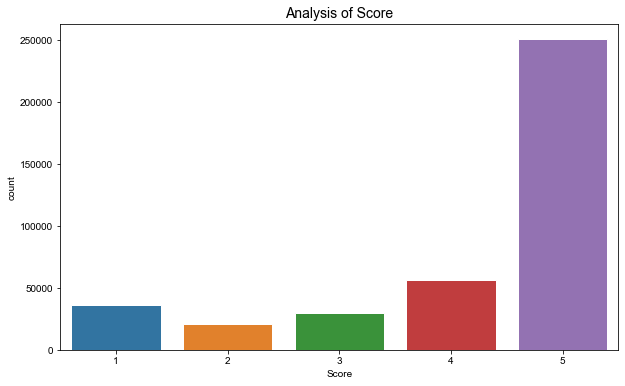

In [31]:
#countplot of score
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Analysis of Score',fontsize=14)
sns.set_style('whitegrid')
sns.countplot(x='Score',data=df)

From the countplot it is clear that most of the reviews have score 5 and very less reviwes have score 2

##### word count distribution plot

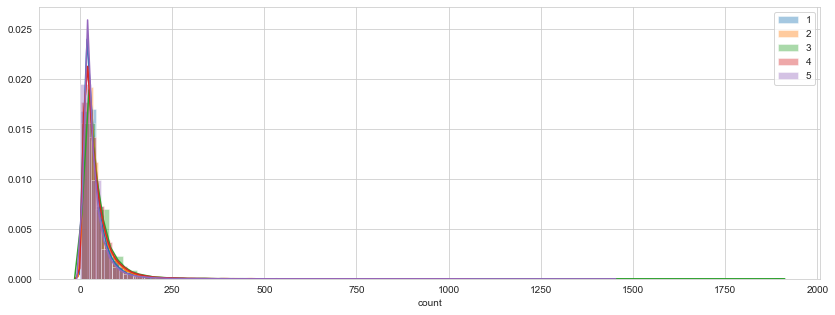

In [32]:
plt.figure(figsize=(14,5))
_ = sns.distplot(df[df['Score']==1]['count'])#.set_title('Tweet length distribution')
_ = sns.distplot(df[df['Score']==2]['count'])
_ = sns.distplot(df[df['Score']==3]['count'])
_ = sns.distplot(df[df['Score']==4]['count'])
_ = sns.distplot(df[df['Score']==5]['count'])

plt.legend(['1','2','3','4','5'])
plt.show()

From the Distribution plot we can understand that the length of the reviews are in the range  of 0 to 250.

In [33]:
#df.text_length.max()

In [34]:
df['count'].max()

1895

In [35]:
#df[df.text_length == df.text_length.max()]


In [36]:
df.index.get_loc(df['count'].max())

1892

In [37]:
df['Text'].iloc[1918]

'I\'ve had a couple of these for a few years but find that I don\'t use them all that often because their size & design limits their usefulness. For bushy herbs like cilantro or parsley it only holds a small bunch, and it\'s difficult to keep the bunch together while you snap the lid back on. Since the bottom cup is so shallow herbs tend to flop out the front unless you lay the pod down when first filling it. It works great for asparagus, but only for small-ish bunches and if the spears aren\'t too tall.<br /><br />More often than not I simply use a canning jar + 1/2" of water with a plastic bag over the top, which keeps the contents just as fresh and allows for easier access. These pods do look much nicer in the fridge than a bag-topped-jar, however, and the clear front makes it harder to forget what\'s in there.<br /><br />They are definitely well made and not prone to leaking or tipping over. And the little drain port is fun to use.<br /><br />But it only works for small bunches.'

In [38]:
df['clean_text'].iloc[1918]

'couple years find use often size design limit usefulness bushy herbs like cilantro parsley hold small bunch difficult keep bunch together snap lid back since bottom cup shallow herbs tend flop front unless lay pod first fill work great asparagus smallish bunch spear tallmore often simply use jar water plastic bag top keep content fresh allow easier access pod look much nicer fridge bagtoppedjar however clear front make harder forget therethey definitely well make prone leak tip little drain port fun usebut work small bunch'

In [39]:
#df.index.get_loc(df['text_length'].max())

In [40]:
#df['clean_text'].iloc[13333]

In [41]:
#print(df[df.text_length == df.text_length.max()]) 

In [42]:
#print(df[df.text_length == df.text_length.max()]) 

In [43]:

#print(df[df["Text"].str.contains("Fuzzy Wuzzy's Summary", na=False)])

In [44]:
#df['Text'].iloc[290807]
#df['clean_text'].str.len()              

In [45]:
#d=df['Text'].iloc[290807]


In [46]:
#df['clean_text'].iloc[290807]

In [47]:
#df.drop(df.loc[df['line_race']==0].index, inplace=True)

# Sentiment Analysis

Sentiment analysis is basically the process of determining the attitude or the emotion of the writer, i.e., whether it is positive or negative or neutral.


The sentiment function of textblob returns two properties, polarity, and subjectivity.

#### Finding the polarity of the review using TextBlob


In [48]:
from textblob import TextBlob
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity
df['polarity']=df['clean_text'].apply(lambda x:detect_polarity(x))
df.head()

,Score,Summary,Text,clean_text,count,polarity
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,buy several vitality dog food products find go...,22,0.425000
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrive label jumbo salt peanutsthe pea...,18,0.216667
2,4,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...,39,0.187000
3,2,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredient robitussin believe find...,18,0.150000
4,5,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,13,0.458333


Polarity is float which lies in the range of [-1.0,1.0] where 1 means positive statement and -1 means a negative statement.

#### Finding the subjectivity of the review using TextBlob

In [49]:
def detect_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity
df['subjectivity']=df['clean_text'].apply(lambda x:detect_subjectivity(x))
df.head()

,Score,Summary,Text,clean_text,count,polarity,subjectivity
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,buy several vitality dog food products find go...,22,0.425000,0.400000
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrive label jumbo salt peanutsthe pea...,18,0.216667,0.762963
2,4,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...,39,0.187000,0.548000
3,2,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredient robitussin believe find...,18,0.150000,0.650000
4,5,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,13,0.458333,0.600000


Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

In [50]:

def polarity_analysis(p):
    
    if p >.25:
        return 'Positive'
    elif p<0:
        return 'Negative'
   
    else:
        return 'Neutral'
df['Sentiment']=df['polarity'].apply(lambda x:polarity_analysis(x))
df.head()

,Score,Summary,Text,clean_text,count,polarity,subjectivity,Sentiment
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,buy several vitality dog food products find go...,22,0.425000,0.400000,Positive
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrive label jumbo salt peanutsthe pea...,18,0.216667,0.762963,Neutral
2,4,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...,39,0.187000,0.548000,Neutral
3,2,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredient robitussin believe find...,18,0.150000,0.650000,Neutral
4,5,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,13,0.458333,0.600000,Positive


I have classified the reviews into three,Positive,Negative and Neutral based on the polarity.

In [51]:
max_polarity=df['polarity'].max()
max_polarity

1.0

In [52]:
min_polarity=df['polarity'].min()
min_polarity

-1.0

Positive    187974
Neutral     167718
Negative     37884
Name: Sentiment, dtype: int64

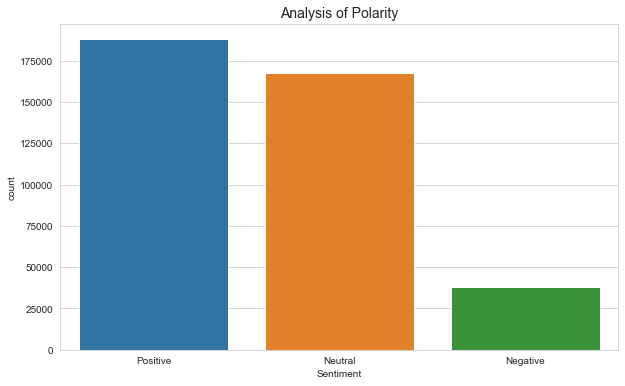

In [53]:
plt.figure(figsize=(10,6))
plt.title('Analysis of Polarity',fontsize=14)
sns.set_style('whitegrid')
sns.countplot(x='Sentiment',data=df)
df['Sentiment'].value_counts()


The above figure shows the distribution of polarity among reviews. Most of the reviews are classified as positive and a very less reviews classified as Negative.


In [54]:
pos_idx = df[(df.Score==5) & (df.polarity == 1)].index[0]
neg_idx = df[(df.Score==1) & (df.polarity == -1)].index[0]

print('Most Negative Review:', df.iloc[neg_idx][['Text']][0])
print()
print('Most Positive Review:', df.iloc[pos_idx][['Text']][0])

Most Negative Review: Unless you like salt vinegar chips as salty as eating actual pinches of salt and drinking actual vinegar, i doubt you will like these chips.  These are the saltiest & sourest chips I have ever had, and the only reason stops me from throwing these away is because I paid for 2 full boxes and dont like to waste food.  The brown chips are especially bad, besides being salty and sour, they also taste overcooked and burnt.  Unless you are the rare kind that can take this kind of extreme taste, you will not like these chips.<br /><br />I actually have a high tolerance for sour taste, so I can down a bag of chips with a bit of difficulty.  But normal people, please do not try this at home.

Most Positive Review: I can remember buying this candy as a kid and the quality hasn't dropped in all these years. Still a superb product you won't be disappointed with.


In [59]:
df_pos = df.loc[df['Sentiment'] == 'Positive' ]
df_neu =df.loc[df['Sentiment'] == 'Negative']
df_neg=df.loc[df['Sentiment'] == 'Neutral']

In [70]:
df_pos = df.loc[df['Score'] ==5] 
df_neu = df.loc[df['Score'] ==3] 
df_neg = df.loc[df['Score'] ==1] 

#### Word cloud 

WordCloud is a  visual representation of text data, typically used to depict keyword metadata (tags) on websites, or to visualize free form text. Tags are usually single words, and the importance of each tag is shown with font size or color. This format is useful for quickly perceiving the most prominent terms to determine its relative prominence. 

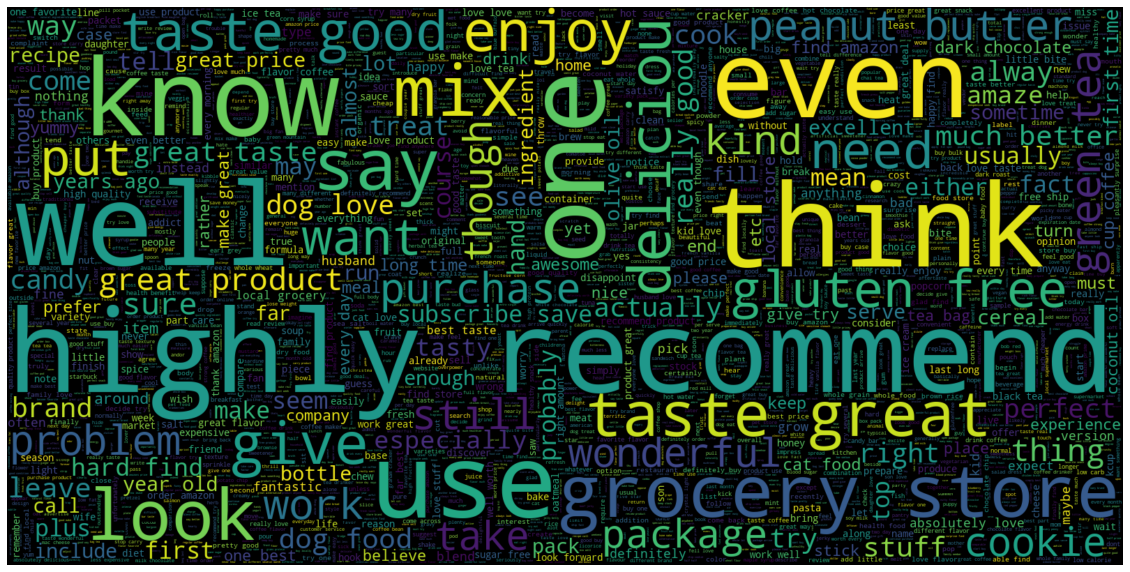

In [71]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_pos['clean_text']))
plt.axis('off')
plt.imshow(wc , interpolation = 'bilinear')

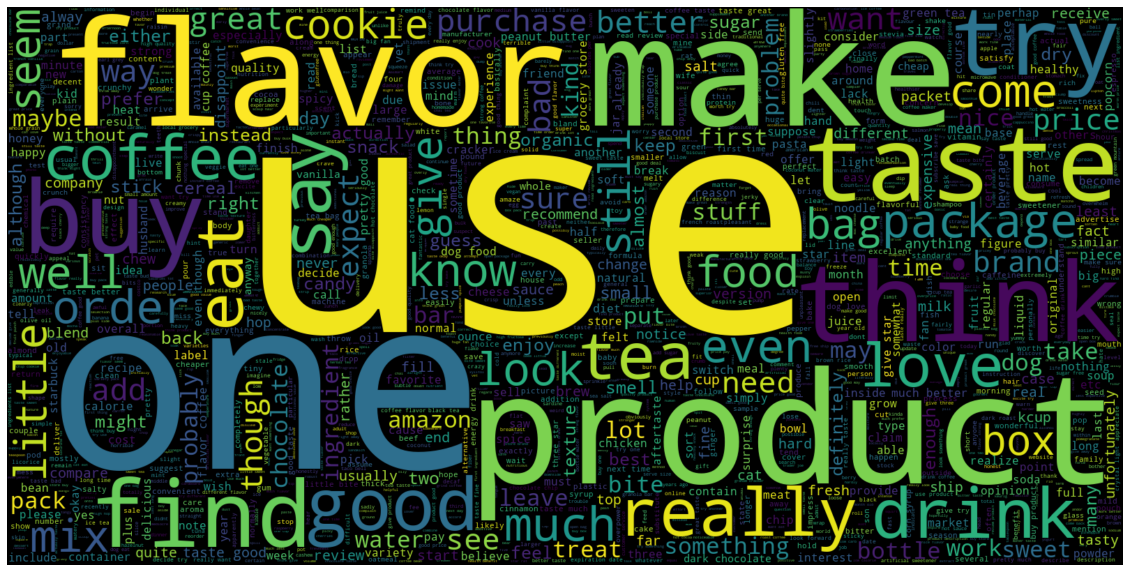

In [65]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 3000,width=1600,height=800 , stopwords = STOPWORDS).generate(" ".join(df_neu['clean_text']))
plt.axis('off')
plt.imshow(wc , interpolation = 'bilinear')

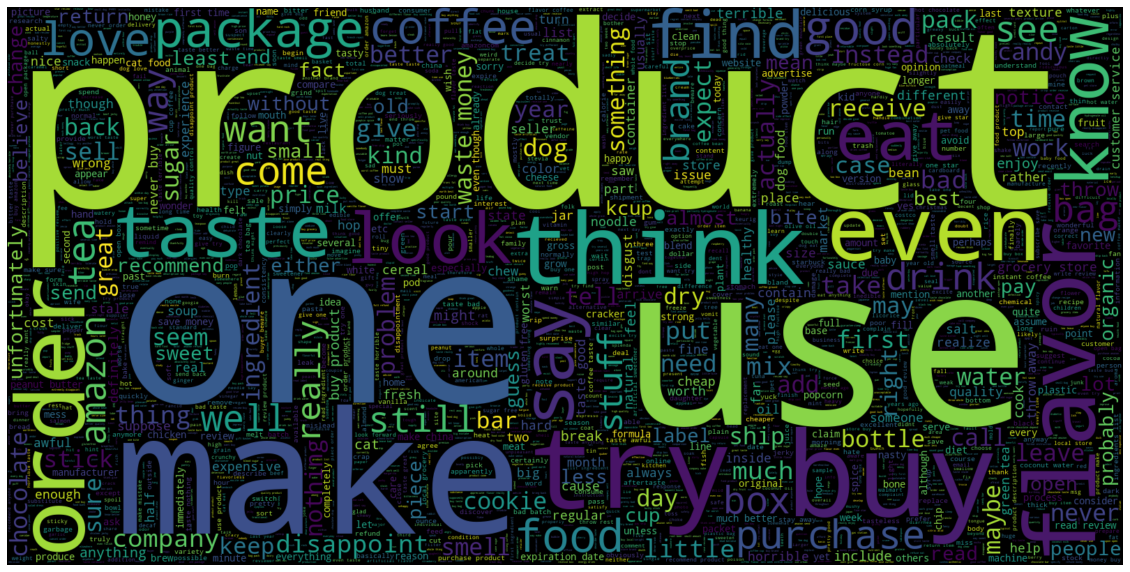

In [69]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 3000,width=1600,height= 800,stopwords = STOPWORDS).generate(" ".join(df_neg['clean_text']))
plt.axis('off')
plt.imshow(wc , interpolation = 'bilinear')

#### Analysis of Sentiment Vs Score

In [72]:
p=df.groupby([ 'Sentiment','Score'])[['Sentiment']].count()
p.unstack()

Sentiment                             
Score             1      2      3      4       5
Sentiment                                       
Negative      13655   4835   4187   3964   11243
Neutral       17605  11804  17232  27661   93416
Positive       5015   4152   8333  24417  146057

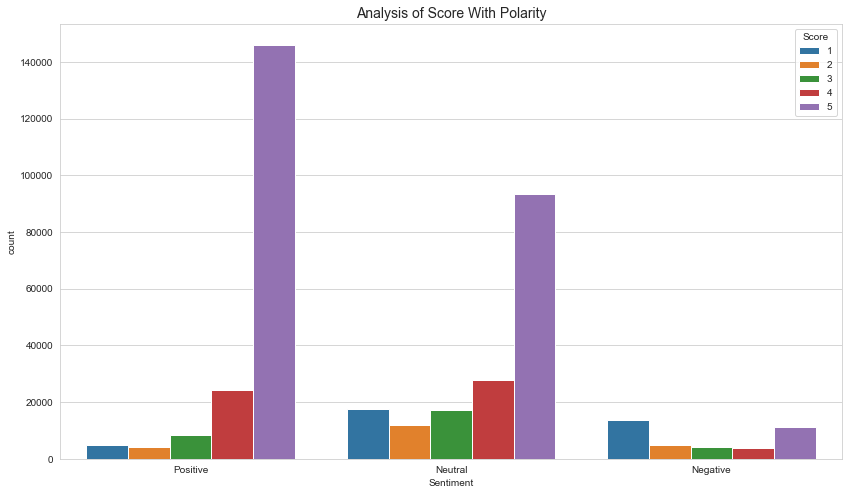

In [73]:
plt.figure(figsize=(14,8))
plt.title('Analysis of Score With Polarity',fontsize=14)
sns.set_style('whitegrid')
sns.countplot(x='Sentiment', hue="Score", data=df)

Most of the positive reviews got score 5, but there are few positive reviews, which got very less Score. On the other side some of the negative reviews got high rating.

#### Polarity vs Subjectivity

Text(0, 0.5, 'Subjectivity')

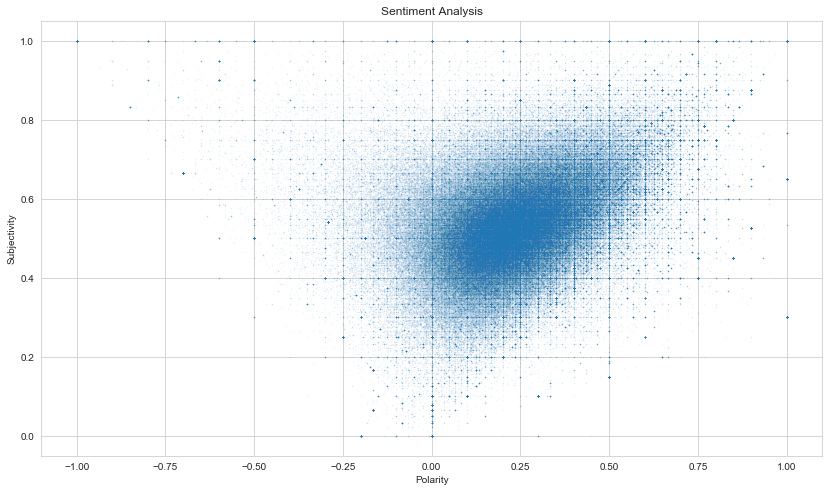

In [74]:
plt.figure(figsize=(14,8))
plt.scatter(df['polarity'],df['subjectivity'],alpha=0.1,s=0.12)
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

The scatter plot tells us that,most of the people are happy with Amazon food services.

#### Analysis of positive ang negative words

In [75]:
#Create function to combine all tokens in clean_text column into one list

def tokenize_to_list(text):
    allTokens = []
    tokenized = text.apply(word_tokenize)
    for token in tokenized:
        allTokens += token
    return allTokens

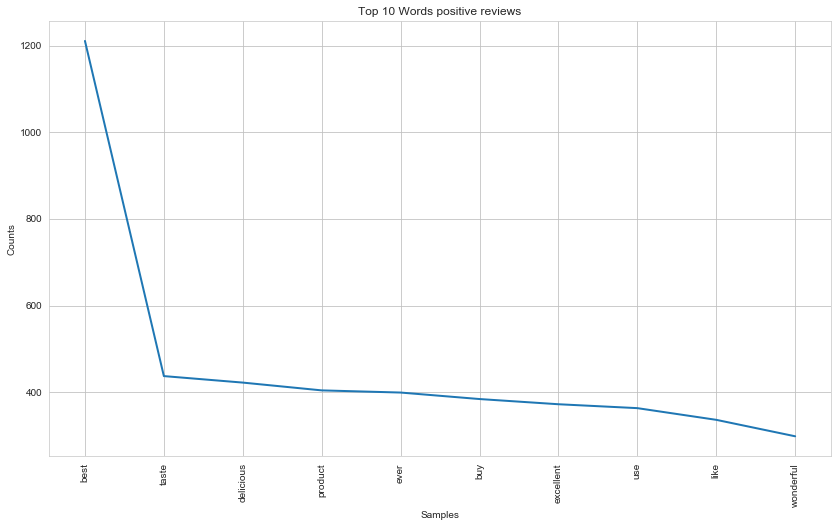

Top 10 Words for positive reviews


[('best', 1211),
 ('taste', 437),
 ('delicious', 422),
 ('product', 404),
 ('ever', 399),
 ('buy', 384),
 ('excellent', 372),
 ('use', 363),
 ('like', 336),
 ('wonderful', 298)]

In [79]:
#Tokens to a single list for No target
from nltk.probability import FreqDist
allTokens_5 = tokenize_to_list(df[df['polarity']==1]['clean_text'])

# Frequency Distribution in NLTK was used in order to find the common words.
fdist_5 = FreqDist(allTokens_5)

#Plot top 10 words
plt.figure(figsize=(14,8))
_ = fdist_5.plot(10, title='Top 10 Words positive reviews')

#Print top 10 words

print('Top 10 Words for positive reviews')
fdist_5.most_common(10)

The above list shows the words used to express positive reviews. And the word <b>best</b> is used 1141 times.

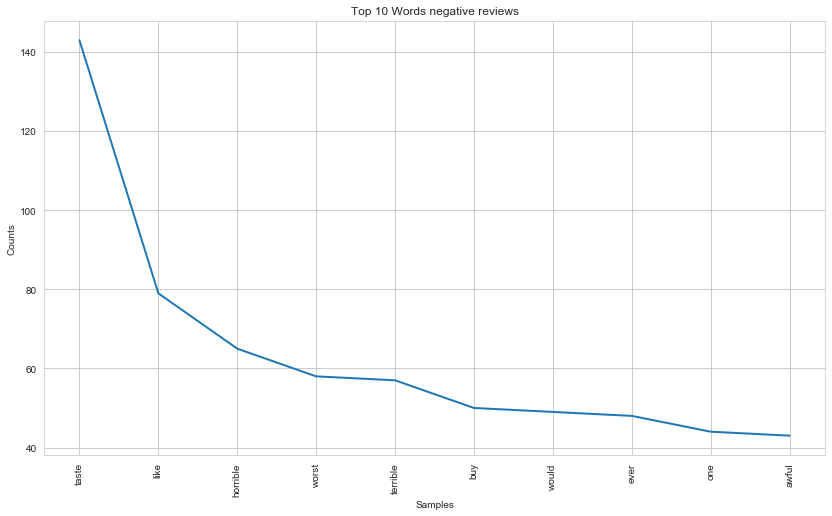

Top 10 Words for negative reviews


[('taste', 143),
 ('like', 79),
 ('horrible', 65),
 ('worst', 58),
 ('terrible', 57),
 ('buy', 50),
 ('would', 49),
 ('ever', 48),
 ('one', 44),
 ('awful', 43)]

In [80]:
#Tokens to a single list for No target
allTokens_1 = tokenize_to_list(df[df['polarity']==-1]['clean_text'])

# Frequency Distribution in NLTK was used in order to find the common words.
fdist_1 = FreqDist(allTokens_1)

#Plot top 10 words
plt.figure(figsize=(14,8))
_ = fdist_1.plot(10, title='Top 10 Words negative reviews')

#Print top 10 words

print('Top 10 Words for negative reviews')
fdist_1.most_common(10)


The above list represents the most common words used to express negative reviews.
